# Imports

In [1712]:
import json
import math
import pandas as pd
from IPython.display import clear_output
from sign_language_translator.text import tokens, vocab, utils
from sign_language_translator import DATASET_ROOT_DIRECTORY
from sign_language_translator.models.language_models import simple_language_model, beam_sampling, mixer, abstract_language_model
from importlib import reload
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

reload(tokens)
reload(utils)
reload(beam_sampling)
reload(abstract_language_model)
reload(simple_language_model)
reload(mixer)
clear_output()

stok = tokens.SignTokenizer(vocab=vocab.UNCONTEXTED_VOCAB['urdu'], drop_spaces=True)

# ngram dataset

In [ ]:
DRP = "/Users/mudassar.iqbal/Library/CloudStorage/GoogleDrive-mdsriqb@gmail.com/My Drive/sign-language-translator/sign-language-datasets"

In [1613]:
with open(DRP+'/text_corpora/supported_substrings_frequency.json', 'r') as f:
    urdu = json.load(f)
tokenized = {
    k: [
        s
        for seq, freq in urdu[k].items()
        for s in [stok.tokenize(seq)] * max(1, round(freq * 1))
    ]
    for k in urdu.keys()
}
tokenized.keys()

In [1615]:
model_sizes = [1,2,3,4]
slms = [
    simple_language_model.SimpleLanguageModel(window_size=w, unknown_token="<unk>")
    for w in model_sizes
]
[lm.fit     (tokenized['glosbe'   ]     ) for lm in tqdm(slms, desc="glosbe",    leave=False)]
[lm.finetune(tokenized['wikipedia'], 1/2) for lm in tqdm(slms, desc="wikipedia", leave=False)]
[lm.finetune(tokenized['passage'  ], 1/3) for lm in tqdm(slms, desc="passage",   leave=False)]
[lm.finetune(tokenized['poetry'   ], 1/4) for lm in tqdm(slms, desc="poetry",    leave=False)]
lm = mixer.Mixer(slms, model_sizes)
beam = beam_sampling.BeamSampling(lm, beam_width=2.5)
lm

100%|██████████| 4/4 [03:21<00:00, 50.40s/it]


'sign_language_translator.models.language_models.mixer.Mixer'

Mixer LM: unk_tok="<unk>"[4]
├── Simple LM: unk_tok="<unk>", window=1, params=364973 | prob=10.0%
├── Simple LM: unk_tok="<unk>", window=2, params=1679557 | prob=20.0%
├── Simple LM: unk_tok="<unk>", window=3, params=2414412 | prob=30.0%
└── Simple LM: unk_tok="<unk>", window=4, params=2226337 | prob=40.0%

### `Write`

In [1711]:
stok.detokenize(beam(["ایک"])[0])

'ایک آسٹریلوی - انگریزی نام سے اردو نام میں استعمال نہیں کرتی ہے، اس لئے ان کی عمر 86 سال ہے۔۔۔۔۔۔۔ ؛ اجازت دی'

In [1736]:
stok2 = tokens.SignTokenizer(vocab=vocab.CONTEXTED_VOCAB['urdu'], drop_spaces=True)
with open(DATASET_ROOT_DIRECTORY + '/text_corpora/urdu_corpus.txt')  as f:
    corpus = f.read().splitlines()
    tokenized_corpus = [stok2.tokenize(l) for l in corpus]

[line for line in tokenized_corpus
 if any(tok in vocab.AMBIGUOUS_TO_CONTEXTED["pk-hfad"]['urdu'] 
        for tok in line)]

[['یہ', 'اُس', 'کی', 'بیوی', 'تھی', '۔'],
 ['اُسے', 'مدد', 'کی', 'ضرورت', 'ہے', '۔'],
 ['آپ', 'کے', 'لیے', 'افسردہ', 'ہوں', '۔'],
 ['ان(اُن)', 'کی', 'عمر', '8', '6', 'سال', 'ہے', '۔']]

In [1735]:
# "اُس" in vocab.SUPPORTED_WORD_TO_LABEL["pk-hfad"]['urdu']
vocab.AMBIGUOUS_TO_CONTEXTED["pk-hfad"]['urdu']

['ان(اُن)', 'ان(اِن)']

# Create New Names

In [1570]:
df = pd.read_csv('../../sign_language_translator/datasets/sign_recordings/temp/names.csv')
data = [f"[{name}]" for name in df.english_name.to_list()]
data[:5]

['[abeera]', '[abida]', '[abiha]', '[afshan]', '[aiman]']

In [1737]:
slm = simple_language_model.SimpleLanguageModel(window_size=2, unknown_token="")
slm.fit(data)

In [106]:
seq = '[s'
for _ in range(20):
    nxt, prob = slm.next(seq)
    seq += nxt
    if nxt in [']' , slm.unknown_token]:
        break
seq, seq in data

('[saqib]', False)

In [1738]:
lms = [simple_language_model.SimpleLanguageModel(window_size=w, unknown_token="", sampling_temperature=0.95) for w in range(1,4)]
[lm.fit(data) for lm in lms]
mix = mixer.Mixer(lms, [1,10,4], name="Pakistani Names", unknown_token="")
mix

'sign_language_translator.models.language_models.mixer.Mixer'

Mixer LM: name="Pakistani Names", unk_tok=""[3]
├── Simple LM: unk_tok="", window=1, params=282 | prob=6.7%
├── Simple LM: unk_tok="", window=2, params=800 | prob=66.7%
└── Simple LM: unk_tok="", window=3, params=1200 | prob=26.7%

In [1149]:
seq = '['
for _ in range(20):
    nxt, prob = mix.next(seq)
    seq += nxt
    if nxt in [']' , mix.unknown_token]:
        break
seq, ("new" if seq not in data else "old")

('[khuzaib]', 'new')

In [ ]:
slm.__dict__

In [1739]:
beam = beam_sampling.BeamSampling(mix, beam_width=2.5)

In [1760]:
name,_ = beam('[')
name, name in data

('[arshashir]', False)

# Model Visualization

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

slm = simple_language_model.SimpleLanguageModel(window_size=1, unknown_token="")
slm.fit(data)

def get_next(parent = '[', top_n=3):
    weights = slm.model[tuple(parent)][slm.WEIGHTS]
    words = slm.model[tuple(parent)][slm.NEXT_TOKEN]
    idxs = np.argsort(weights)[::-1][:top_n]
    for i in idxs:
        yield parent, words[i]

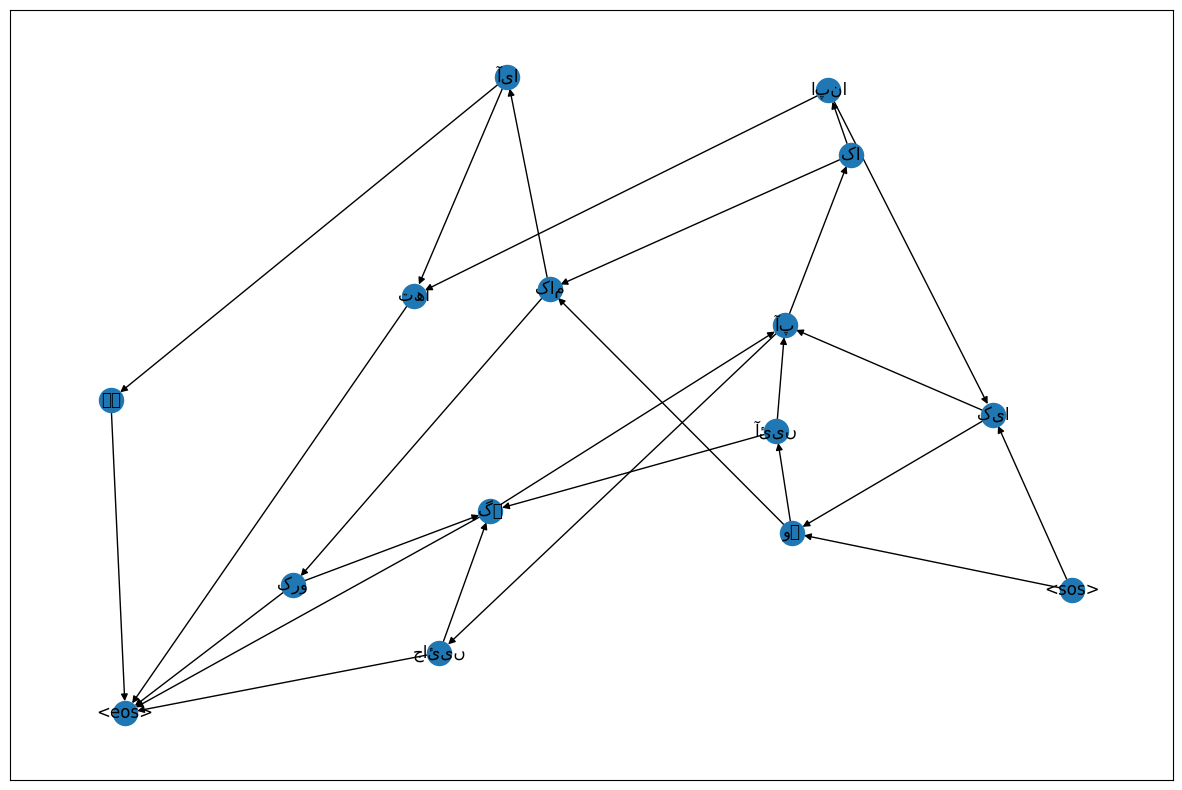

In [ ]:
pairs = []
nodes = {'<sos>'}
done = set()

while len(nodes)>0:
    curr = nodes.pop()
    pairs += list(get_next(curr, top_n=2))
    done.add(curr)
    for _, child in pairs:
        if child not in done and child != "<eos>":
            nodes.add(child)

plt.figure(figsize=(15,10))
G = nx.DiGraph()
G.add_edges_from(pairs)

nx.draw_networkx(G)
plt.show()